# PDF extraction basics


---


## PDFs are difficult.
The pdf format is quite difficult to work with. Think of it as an omelette that's been already cooked. There are many different strategies for handling the data they contain but they are at best reconstructive rather than translative.



---


### Things to watch out for
**If a document is scanned**, you will face additional hurdles to extraction since scanned documents start as an image and are converted through optical character recognition (OCR) into vector text. The OCR process is often imprecise due to the lossy nature of starting with images. These types of documents will require much more work to extract correct information.

**If you have a scanned document you need to work with, see the processes for `Unstructured` or `AWS textract`.**

There are a lot more things that impact the extraction process. If you're curious or running into issues, check out [this link](https://pypdf.readthedocs.io/en/stable/user/extract-text.html#why-text-extraction-is-hard) for a more indepth discussion of the challenges of PDFs as a format.



---


### Whitespace and internal representation in PDFs
One thing that is clear when extracting pdfs is that they often do not maintain correct whitespace. For example, there might be words split at a hyphen at the end of a line and the word will be split with a newline in the output.



> The PDF format is meant for printing. It is not designed to be read by machines. The text within a PDF document is absolutely positioned, meaning that every single character could be positioned on the page. The text

        This is a test document by Ethan Nelson.

> can be represented as

        [(This is a )9(te)-3(st)9( do)-4(cu)13(m)-4(en)12(t )-3(b)3(y)-3( )9(Et)-2(h)3(an)4( Nels)13(o)-5(n)3(.)]

> Where the numbers are adjustments of vertical space. This representation used within the PDF file makes it very hard to guarantee correct whitespaces.

Keep in mind, these issues are significant for just extracting paragraphs from a document. **Tables are far more difficult to reconstruct**. You may need to consult documentation for some of these tools to determine the correct layout parameters to input.

# Setup

**Run this cell before ones below.**

* Install python libraries.
* Setup functions for mounting google drive.

In [ ]:
!uv pip install pydantic amazon-textract-textractor[pdfium] unstructured-ingest[remote] python-dotenv PyPDF pypdf_table_extraction --system

# mount google drive at /content/drive
# For Colab only
from google.colab import drive
from pathlib import Path


def open_drive() -> list[Path, Path, Path]:
    """Mounts Google Drive and creates necessary folders.

    This function mounts Google Drive at `/content/drive` and creates
    three folders: `ingest`, `output`, and `done` inside the
    `/content/drive/MyDrive/Colab Notebooks/pdfs` directory.

    Returns:
        A list of Path objects representing the `ingest`, `output`, and `done` folders.
    """
    drive.mount("/content/drive")
    print("Google Drive mounted at /content/drive")
    parent_dir = Path("/content/drive/MyDrive/Colab Notebooks/pdfs")
    folders = ["ingest", "output", "done"]
    for folder in folders:
        (parent_dir / folder).mkdir(exist_ok=True, parents=True)
    return [(parent_dir / folder) for folder in folders]


def save_and_close_drive() -> None:
    """Saves changes made to Google Drive and unmounts it."""
    print("Saving changes...")
    drive.flush_and_unmount()
    print("All changes made in this colab session should now be visible in Drive.")


Using Python 3.10.12 environment at /usr
Audited 6 packages in 1.18s


# PyPDF text extraction

**Free and open source**

* **Text only**. Not for tables.
* **Good quality pdfs only**. No scans.

This recipe extracts the text from each page, combines the results and saves into the output folder with a suffix of `_pypdf.txt`.

In [4]:
"""Extracts text from PDF files using PyPDF.

This script iterates through PDF files in the 'ingest' folder,
extracts the text content from each page, and saves the combined
text to a new file in the 'output' folder. The output files are
named with the original filename and a '_pypdf.txt' suffix.

The script uses the `pypdf` library for PDF processing. It mounts
Google Drive to access the files and saves the results back to Drive.
"""
import pypdf

ingest, output, done = open_drive()

files = list(ingest.glob("*.pdf"))

text_output = ""
for f in files:
    print(f"Processing {f}")
    pdf = pypdf.PdfReader(str(f))
    print(f"Number of pages: {len(pdf.pages)}")
    for page in pdf.pages:
        text = page.extract_text()
        text_output += f"\n{text}"

    if not text_output.strip():
        print("No text found")
    else:
        output_file = output / f"{f.stem}_pypdf.txt"
        with open(output_file, "w") as f:
            f.write(text_output)
            print(f"Saved to {output_file}")
            text_output = ""
print(output)
save_and_close_drive()

Mounted at /content/drive
Google Drive mounted at /content/drive
Processing /content/drive/MyDrive/Colab Notebooks/pdfs/ingest/FY17 - 1st 9wksADMADA.pdf
Number of pages: 11
Saved to /content/drive/MyDrive/Colab Notebooks/pdfs/output/FY17 - 1st 9wksADMADA_pypdf.txt
/content/drive/MyDrive/Colab Notebooks/pdfs/output
Saving changes...
All changes made in this colab session should now be visible in Drive.


# PyPDF-table-extraction, AKA Camelot

**Free and open source**

Table extraction
* Only **text-based pdf tables**. No scans.
* Customizable layout specifications. See documentation.
* [Documentation](https://pypdf-table-extraction.readthedocs.io/en/latest/)

Flavor options (select the best results):
* **lattice** (default, looks for lines separating cell boundaries.)
    * `process_background=True` for lattice lines that are in the background (formed by negative space)
* **stream** (constructs table based on analysis of whitespace and guesses columns).
* **network**
* **hybrid**

In [ ]:
import pypdf_table_extraction


def pypdf_table_extraction_main(flavor: str = "network") -> None:
    """Extracts tables from PDF files using PyPDF-table-extraction (Camelot).

    This function iterates through PDF files in the 'ingest' folder,
    extracts tables using the specified flavor, and saves them as CSV files
    in the 'output' folder. It uses the `pypdf_table_extraction` library
    (formerly Camelot) for table extraction.

    Args:
        flavor: The table extraction flavor to use. Options are 'lattice',
            'stream', 'network', and 'hybrid'. Defaults to 'network'.

    """

    # get list of files to process from ingest folder
    files = list(ingest.glob("*.pdf"))
    print(f"{files=}")

    # loop through each file and extract all tables
    for f in files:
        print(f"Processing {f}")
        tables = pypdf_table_extraction.read_pdf(
            str(f), flavor=flavor, pages="all", parallel=True
        )
        if not tables:
            print("No tables found")
            continue
        else:
            print(f"Number of tables: {tables.n}")
        for n, table in enumerate(tables):
            # plot detection overlay on page image
            # pypdf_table_extraction.plot(table, kind='text').show()
            output_file = output / f"{f.stem}_pte_table_{flavor}_{n}.csv"
            table.to_csv(output_file)
            print(f"Saved to {output_file}")


if __name__ == "__main__":
    # load google drive and set ingest/output paths
    ingest, output, done = open_drive()
    for flavor in ["lattice", "stream", "network", "hybrid"]:
        pypdf_table_extraction_main(flavor)
    save_and_close_drive()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Google Drive mounted at /content/drive
files=[PosixPath('/content/drive/MyDrive/Colab Notebooks/pdfs/ingest/2013-2014_Oklahoma_Public_School_Dropout_Rates.pdf')]
Processing /content/drive/MyDrive/Colab Notebooks/pdfs/ingest/2013-2014_Oklahoma_Public_School_Dropout_Rates.pdf


KeyboardInterrupt: 

# Unstructured API


---


**Low cost api with a free tier**

Go to [Unstructured](https://unstructured.io/api-key-free) and sign up for a free api key. Copy the key and enter it when prompted.

* [API Documentation](https://docs.unstructured.io/api-reference/api-services/overview)
* [Documentation for partition strategy options](https://docs.unstructured.io/api-reference/api-services/partitioning)
* [Documentation for chunking strategy options](https://docs.unstructured.io/api-reference/api-services/chunking)



---


They also provide an open source docker image to run for free locally, but that's beyond this tutorial.
* [Docker Instructions](https://github.com/Unstructured-IO/unstructured-api?tab=readme-ov-file#dizzy-instructions-for-using-the-docker-image)
* Must setup notebook locally to allow access to docker container.
    * create virtual environment
    * install libraries
    * activate environment
    * change UNSTRUCTURED_SERVER_URL to http://localhost:8000/general/v0/general

In [ ]:
import os
import shutil

from dotenv import load_dotenv
from unstructured_ingest.v2.pipeline.pipeline import Pipeline
from unstructured_ingest.v2.interfaces import ProcessorConfig
from unstructured_ingest.v2.processes.connectors.local import (
    LocalIndexerConfig,
    LocalDownloaderConfig,
    LocalConnectionConfig,
    LocalUploaderConfig,
)
from unstructured_ingest.v2.processes.partitioner import PartitionerConfig


def unstructured_main(move_files: bool = False) -> None:
    """Processes PDF files using the Unstructured API.

    This function orchestrates the processing of PDF files using the
    Unstructured API. It performs the following steps:

    1. Mounts Google Drive and sets up input/output directories.
    2. Prompts for an API key if not found in a .env file.
    3. Runs the Unstructured pipeline to process PDF files in the 'ingest' folder,
       partitioning them using the specified strategy and chunking strategy,
       and storing results in the 'output' folder.
    4. Optionally moves processed files from 'ingest' to 'done' folder.
    5. Saves changes to Google Drive and unmounts it.

    Args:
        move_files: Whether to move processed files to the 'done' folder.
                    Defaults to False.
    """
    ingest, output, done = open_drive()

    if not (ingest.parent / ".env").exists():
        api_key = input("Please enter your API key: ")
        with open(str(ingest.parent / ".env"), "w") as f:
            api_url = "'https://api.unstructured.io/general/v0/general'"
            f.write(
                f"UNSTRUCTURED_API_KEY='{api_key}'\n"
                f"UNSTRUCTURED_SERVER_URL={api_url}"
            )

    # load .env to environment
    load_dotenv(str(ingest.parent / ".env"))

    # run pipeline
    Pipeline.from_configs(
        context=ProcessorConfig(),
        indexer_config=LocalIndexerConfig(input_path=str(ingest)),
        downloader_config=LocalDownloaderConfig(),
        source_connection_config=LocalConnectionConfig(),
        partitioner_config=PartitionerConfig(
            partition_by_api=True,
            api_key=os.getenv("UNSTRUCTURED_API_KEY"),
            partition_endpoint=os.getenv("UNSTRUCTURED_SERVER_URL"),
            strategy="auto",
            chunking_strategy="by_title",
            additional_partition_args={
                "split_pdf_page": True,
                "split_pdf_allow_failed": True,
                "split_pdf_concurrency_level": 15,
            },
        ),
        uploader_config=LocalUploaderConfig(output_dir=str(output)),
    ).run()

    # move all files from ingest to done folder
    if move_files:
        for f in ingest.glob("*"):
            shutil.move(f, done)

    # save files out to drive
    save_and_close_drive()


if __name__ == "__main__":
    # toggle this variable to move all files from ingest folder to done folder
    # on completion
    move_files = False
    unstructured_main(move_files)


Mounted at /content/drive
Google Drive mounted at /content/drive


2024-11-20 13:40:43,754 MainProcess INFO     Created index with configs: {"input_path": "/content/drive/MyDrive/Colab Notebooks/pdfs/ingest", "recursive": false}, connection configs: {"access_config": "**********"}
2024-11-20 13:40:43,759 MainProcess INFO     Created download with configs: {"download_dir": null}, connection configs: {"access_config": "**********"}
2024-11-20 13:40:43,761 MainProcess INFO     Created partition with configs: {"strategy": "hi_res", "ocr_languages": null, "encoding": null, "additional_partition_args": {"split_pdf_page": true, "split_pdf_allow_failed": true, "split_pdf_concurrency_level": 15}, "skip_infer_table_types": null, "fields_include": ["element_id", "text", "type", "metadata", "embeddings"], "flatten_metadata": false, "metadata_exclude": [], "metadata_include": [], "partition_endpoint": "https://api.unstructuredapp.io/general/v0/general", "partition_by_api": true, "api_key": "*******", "hi_res_model_name": null}
2024-11-20 13:40:43,764 MainProcess I

Saving changes...
All changes made in this colab session should now be visible in Drive.


## Parse Unstructured results

In [ ]:
from __future__ import annotations
import json
from io import StringIO
from typing import Any, List, Optional

import pandas as pd
from pydantic import BaseModel, RootModel
from rich import print


class RecordLocator(BaseModel):
    path: str


class PermissionsDatum(BaseModel):
    mode: int


class DataSource(BaseModel):
    url: Any
    version: Any
    record_locator: RecordLocator
    date_created: Any
    date_modified: str
    date_processed: str
    permissions_data: List[PermissionsDatum]
    filesize_bytes: int


class Metadata(BaseModel):
    filetype: str
    languages: List[str]
    page_number: int
    filename: str
    data_source: DataSource
    parent_id: Optional[str] = None
    text_as_html: Optional[str] = None


class ModelItem(BaseModel):
    type: str
    element_id: str
    text: str
    metadata: Metadata


class Model(RootModel):
    root: List[ModelItem]


def parse_unstructured_results() -> None:
    """Parses JSON results from Unstructured API and extracts tables to CSV.

    This function reads JSON files output by the Unstructured API,
    locates tables within the data, and extracts them as pandas
    DataFrames. If multiple tables are found within a single JSON
    file, they are concatenated into a single DataFrame if possible and saved.
    If concatenation is not possible, each table is saved as a separate CSV
    file.

    The function assumes the JSON files are located in the 'output'
    folder and saves the CSV files to the same directory.
    """
    ingest, output, done = open_drive()
    results = {}
    if files := output.glob("*.json"):
        for f in files:
            with open(f, "r") as fi:
                data = json.load(fi)
                document = Model(data)
                results[f.stem] = document.root
    for k, v in results.items():
        dfs = []
        for i in v:
            if i.metadata.text_as_html:
                table = StringIO(i.metadata.text_as_html)
                df = pd.read_html(table)[0]
                df = df.reset_index(drop=True)
                dfs.append(df)
        if dfs:
            try:
                df = pd.concat(dfs, join="outer", ignore_index=True)
                df.to_csv(output / f"{k}_unstructured_table.csv")
            except Exception:
                print(f"Error joining dataframes for {k}")
                print("Saving tables individually...")
                for n, df in enumerate(dfs):
                    df.to_csv(output / f"{k}_unstructured_table_{n}.csv")
        else:
            print(f"No tables found for {k}")
            continue


if __name__ == "__main__":
    parse_unstructured_results()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Google Drive mounted at /content/drive

No tables found for Superintendent_CBA2.pdf

No tables found for Superintendent_CBA.pdf

Error joining dataframes for FY17 - 1st 9wksADMADA.pdf

Saving tables individually...

# AWS Textract --> Textractor library

---


**Best results overall, but setup is rough.**


---


* Documentation: https://aws-samples.github.io/amazon-textract-textractor/index.html





---



Use textract for

* tables with merged cells
* tables that are scanned
* form key-value extraction
* recognizing text in images



---


### Setup
* Setup through AWS. Processing anything other than images needs to be done through their asynchronous API. Sending an image is much simpler than a pdf.
* Follow along with this guide: https://docs.aws.amazon.com/textract/latest/dg/api-async-roles.html
    * setup AWS user
    * setup s3 bucket for textract
    * setup proper roles and permissions for textract access to s3 bucket
    * setup message queue for async processing
    * setup local environment to pass variables for
        * AWS_ACCESS_KEY_ID
        * AWS_SECRET_ACCESS_KEY
        * AWS_DEFAULT_REGION
    


In [ ]:
from textractor.entities.document import Document
from textractor.textractor import Textractor
from textractor.data.constants import TextractFeatures
from dotenv import load_dotenv


def textract_tables(files) -> None:
    ingest, output, _ = open_drive()
    load_dotenv(str(ingest.parent / ".env"))
    txt = Textractor(region_name="us-west-2")
    for filename in files:
        document = txt.start_document_analysis(
            s3_upload_path="s3://cedr-textract",
            file_source=str(filename),
            features=[TextractFeatures.TABLES],
        )
        for n, table in enumerate(document.tables, start=1):
            out_path = output / f"{filename.stem}_textract_{n}.xlsx"
            print(f"Saving table {n} of {len(document.tables)} to {out_path}...")
            table.to_excel(filepath=str(out_path))
    save_and_close_drive()


if __name__ == "__main__":
    files = Path("/content/drive/MyDrive/Colab Notebooks/pdfs/ingest").glob("*.pdf")
    textract_tables(files)


<class 'generator'>

### Visualize bounding boxes for table recognition

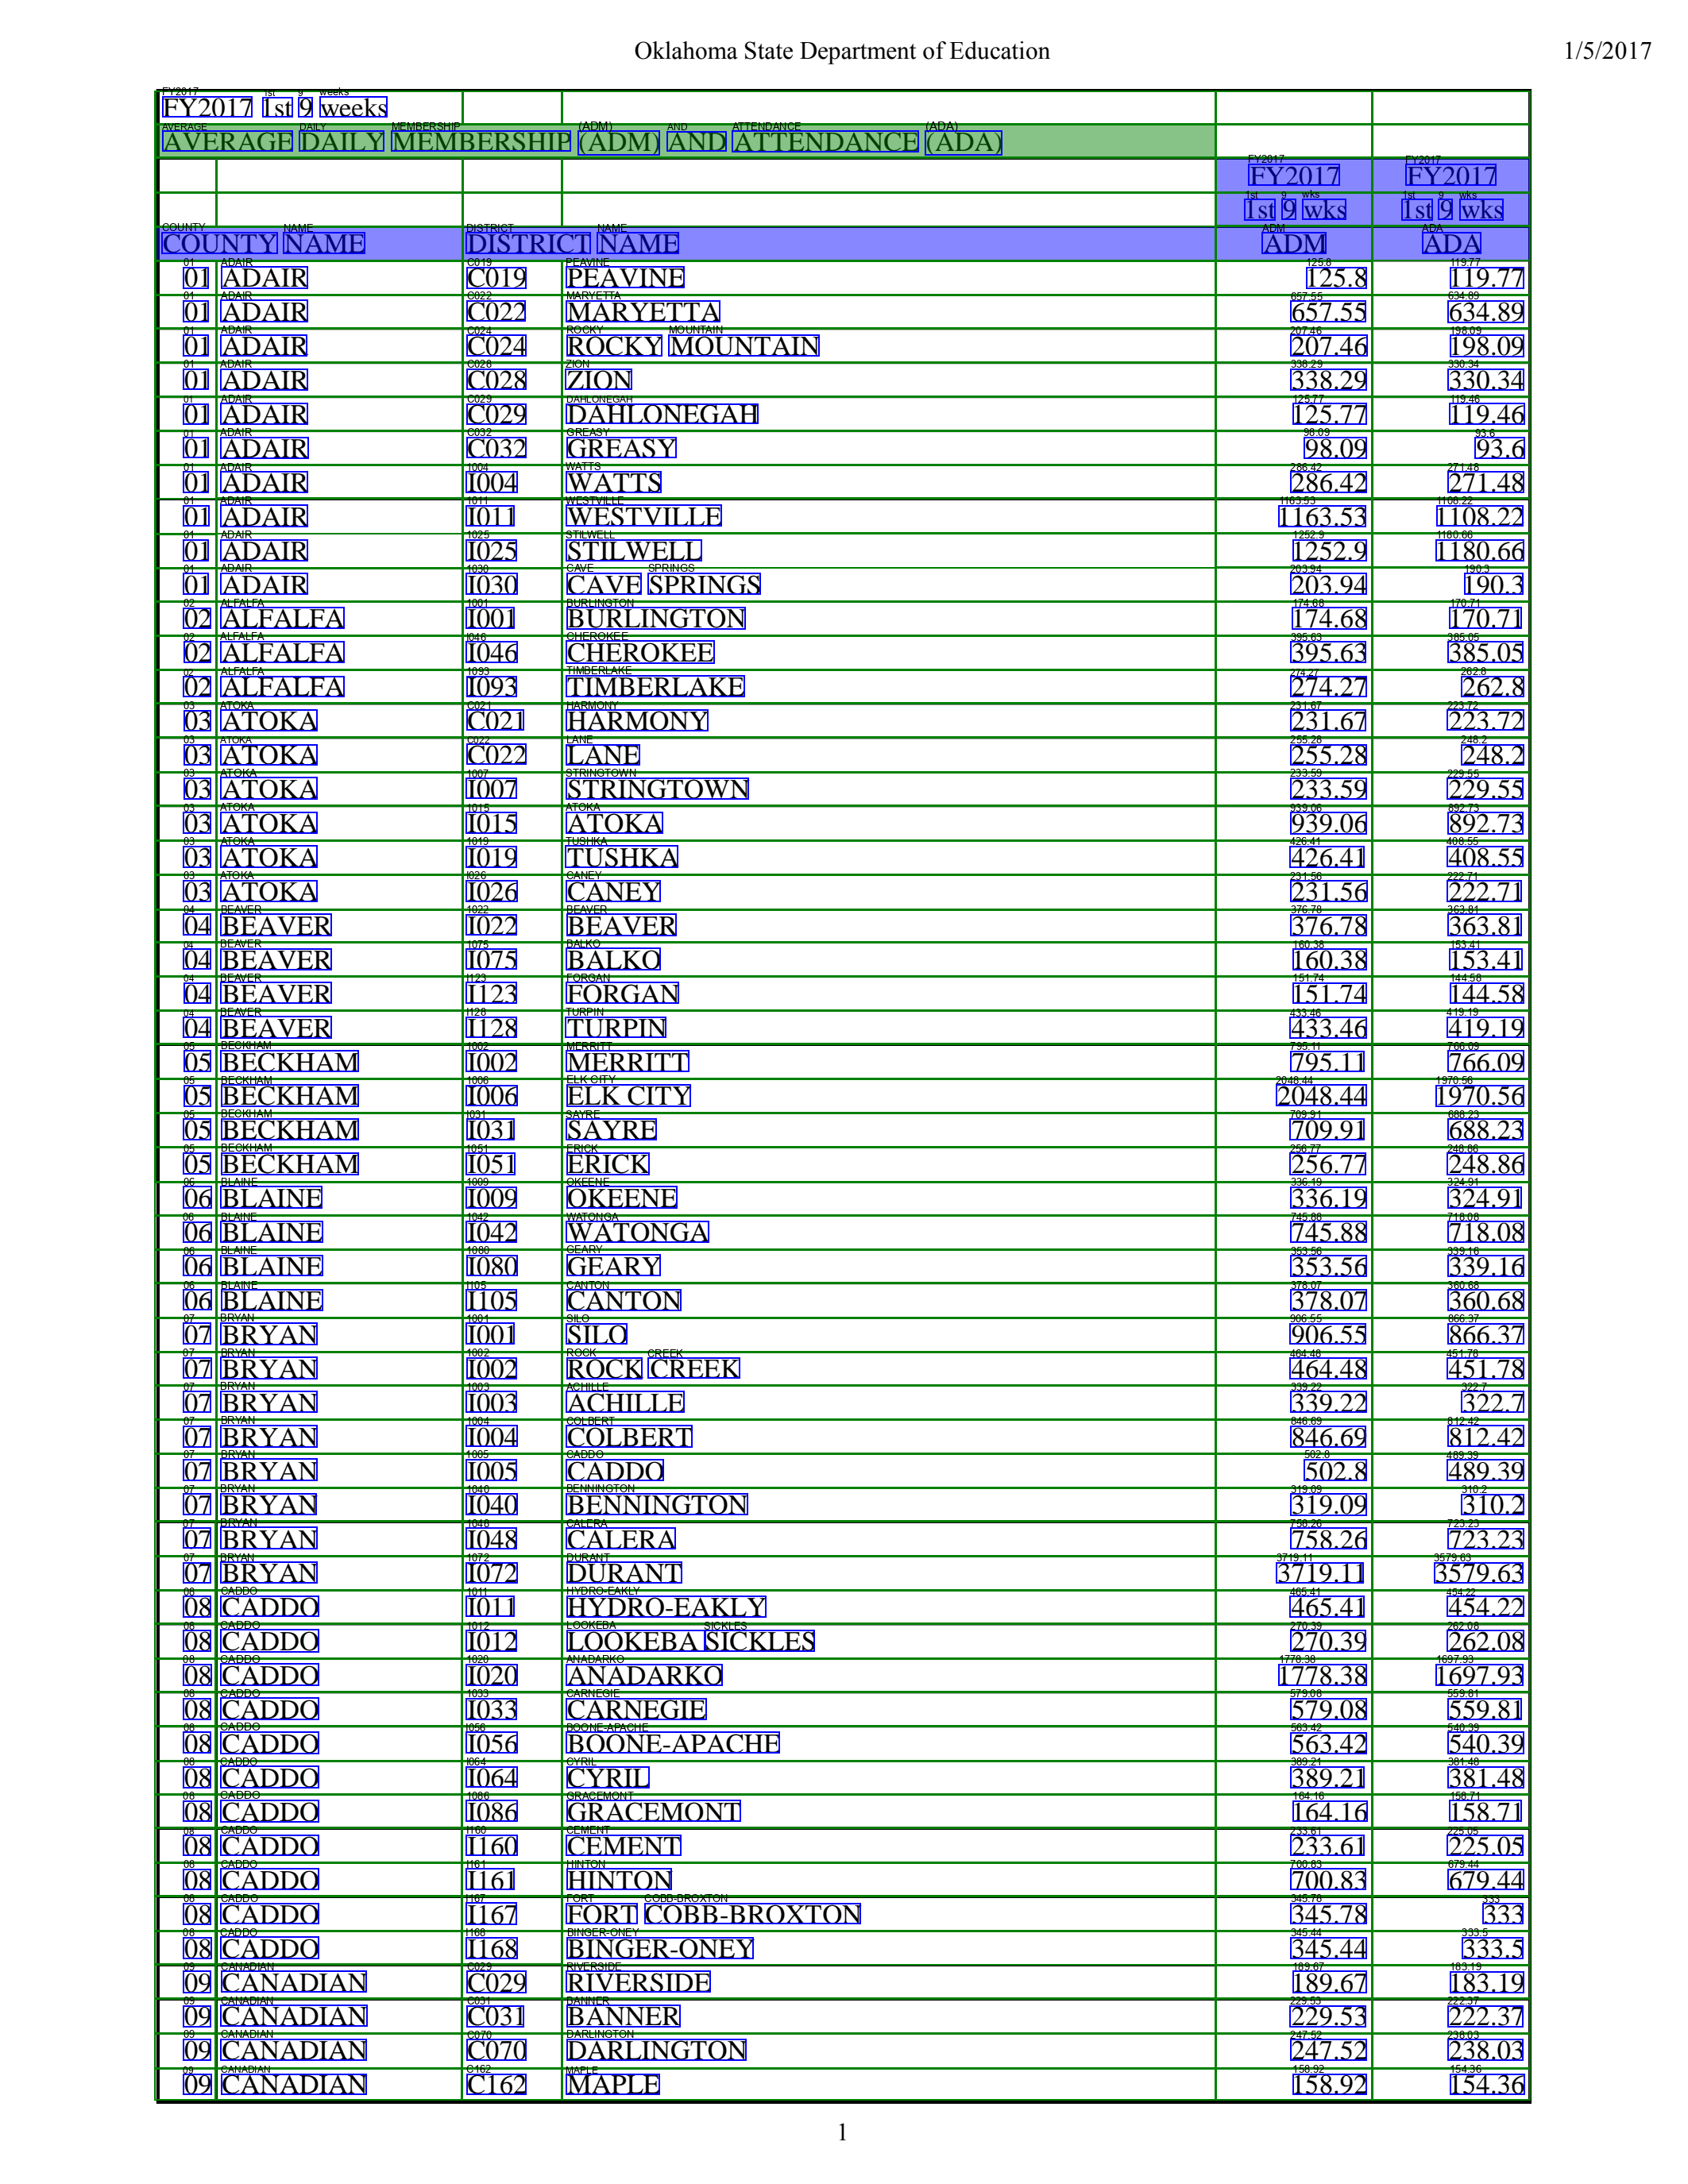

In [34]:
document.tables[0].visualize()